# Node classification using solely node features with multilayer perceptron model

* Cora dataset contains:
  * 2708 publications or nodes.
  * Each reference is an edge.
  * Title of each publication is represented by a binary vector of 1433 unique words. Words exist in the title is represented by 1, otherwise: 0.
  * There are 7 categories of these publications.
* Node classification task in this dataset is to put publications on appropriate categories based on its binary title vector.

In [1]:
# import dataset
try:
    from torch_geometric.datasets import Planetoid
except:
    !pip install -q torch-geometric
    from torch_geometric.datasets import Planetoid

# Download Cora dataset
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [2]:
# Cora feature shape:
#     2708 is the number of publications
#     1433 is the length of the binary title

print(f"Cora dataset shape: {(data.x).shape}")

Cora dataset shape: torch.Size([2708, 1433])


In [3]:
# Cora labels (0->6)
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

In [4]:
# visualize Cora with pandas
import pandas as pd

df = pd.DataFrame(data.x)
df['label'] = pd.DataFrame(data.y)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [5]:
# create multilayer perceptron class
import torch
from torch import nn

class mlp(torch.nn.Module):
    """Multilayer perceptron
        dim_in: number of features
        dim_h: number of hidden layers
        dim_out: number of categories"""

    def __init__(self, dim_in: int, dim_h: int, dim_out: int):
        super().__init__()
        self.mlpBlock = nn.Sequential(
            nn.Linear(in_features=dim_in, out_features=dim_h),
            nn.ReLU(),
            nn.Linear(in_features=dim_h, out_features=dim_out)
        )

    def forward(self, x:torch.Tensor):
        return nn.functional.log_softmax(self.mlpBlock(x), dim=1)


In [6]:
# create an mlp instance
model = mlp(
    dim_in=dataset.num_features,
    dim_h=16,
    dim_out=dataset.num_classes
)
model

mlp(
  (mlpBlock): Sequential(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=7, bias=True)
  )
)

In [7]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=5e-4)

# setup accuracy metric
def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum() / len(y_pred)

In [8]:
# setup training function
import torch_geometric
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          data: torch_geometric.data.data.Data,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Adam,
          epochs: int=10,
          print_results: bool=False,
          adjacency = None):

    # initilize training and validating results
    results = {
        'epoch'     : [],
        'train_loss': [],
        'train_acc' : [],
        'val_loss'  : [],
        'val_acc'   : []
    }
    
    # switch to training mode
    model.train()

    # loop over epochs
    for epoch in tqdm(range(epochs)):
        # zero our gradient
        optimizer.zero_grad()
        # compute logit
        if adjacency is not None:
            logit = model(data.x, adjacency)
        else:
            logit = model(data.x)
        # compute train loss
        train_loss = loss_fn(
            input=logit[data.train_mask],
            target=data.y[data.train_mask]
        )
        # train accuracy
        train_acc = accuracy(
            y_pred=torch.argmax(logit[data.train_mask], dim=1),
            y_true=data.y[data.train_mask]
        )
        # back propagation
        train_loss.backward()
        # optimizer step
        optimizer.step()
        # perform training validation every 20 steps
        if epoch % 20 == 0:
            # compute validation loss
            val_loss = loss_fn(
                input=logit[data.val_mask],
                target=data.y[data.val_mask]
            )
            # compute validation accuracy
            val_acc = accuracy(
                y_pred=torch.argmax(logit[data.val_mask], dim=1),
                y_true=data.y[data.val_mask]
            )

            # collecting results every 20 epochs
            results['epoch'].append(epoch)
            results['train_loss'].append(train_loss.item())
            results['train_acc'].append(train_acc.item())
            results['val_loss'].append(val_loss.item())
            results['val_acc'].append(val_acc.item())

            # printing training and validating result every 20 epochs
            if print_results:
                print(f"{epoch:5d} | {train_loss:.3f} | {train_acc:.3f} | {val_loss:.3f} | {val_acc:.3f}")

    # return train and validation results
    return results

def test(model: torch.nn.Module,
        data: torch_geometric.data.data.Data,
        adjacency=None):

    # switch model to evaluation mode
    model.eval()
    with torch.inference_mode():
        if adjacency is not None:
            test_logit = model(data.x, adjacency)
        else:
            test_logit = model(data.x)
            
        test_acc = accuracy(
            y_pred=torch.argmax(test_logit[data.test_mask], dim=1),
            y_true=data.y[data.test_mask]
        )
    # return test accuracy
    return test_acc

In [9]:
# train the model
results = train(
    model=model,
    data=data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=301
)

# compute test accuracy
test_acc = test(
    model=model,
    data=data
)
print(f"Test accuracy: {test_acc*100:.1f}(%)")

  0%|          | 0/301 [00:00<?, ?it/s]

Test accuracy: 56.0(%)


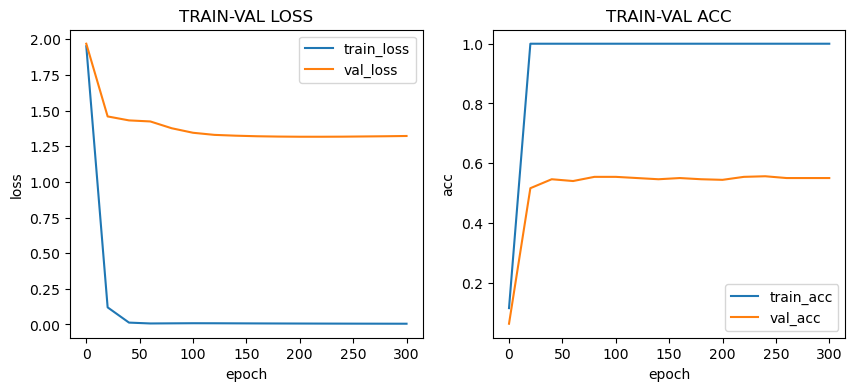

In [10]:
# visualizing training and validating results
from typing import Dict
import matplotlib.pyplot as plt

def visualize_results(results:Dict):
    # create two plots
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # plot train and validation loss
    ax[0].plot(results['epoch'], results['train_loss'], label='train_loss')
    ax[0].plot(results['epoch'], results['val_loss'], label='val_loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].set_title('TRAIN-VAL LOSS')
    ax[0].legend()
    # plot train and validation accuracy
    ax[1].plot(results['epoch'], results['train_acc'], label='train_acc')
    ax[1].plot(results['epoch'], results['val_acc'], label='val_acc')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('acc')
    ax[1].set_title('TRAIN-VAL ACC')
    ax[1].legend()

visualize_results(results=results)

# Node classification using Vanilla Graph Neural Network model taking into account node features and graph topology

* In a regular neural network taking into account only node feature, the linear transformation is fomulated as:

<center>$h_A = x_AW^T$ </center>

<center> $H = XW^T$ </center>

* To take into account neighbor contribution ($N_A$ are neighbor nodes):
<center> $h_A = \sum\limits_{i\in N_A} x_AW^T$ </center>

* In matrix form
<center> $H = \tilde{A}^T XW^T$ </center>
<center> $\tilde{A}^T = A + I$ </center>
* Here: $A$ is adjacency matrix and $I$ is the identity matrix (to take into account the central nodes)

In [11]:
# create adjacency matrix + identity matrix (A+I)
from torch_geometric.utils import to_dense_adj

# get the graph edge
adjacency = to_dense_adj(data.edge_index)[0]

# add identity matrix
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

In [12]:
# create a vanilla GNN layer manually perform matrix multiplication AXW
from torch import nn
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in: int, dim_out: int):
        super().__init__()
        # XW
        self.linear = nn.Linear(in_features=dim_in, out_features=dim_out, bias=False)
    def forward(self, x:torch.Tensor, adjacency):
        # A (XW)
        return torch.sparse.mm(adjacency, self.linear(x))

In [13]:
# create vanilla GNN class
class VanillaGNN(torch.nn.Module):
    
    def __init__(self, dim_in:int, dim_h:int, dim_out:int):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in=dim_in, dim_out=dim_h)
        self.gnn2 = VanillaGNNLayer(dim_in=dim_h, dim_out=dim_out)
        
    def forward(self, x: torch.Tensor, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return nn.functional.log_softmax(h, dim=1)

In [14]:
# create a vanilla GNN instance
model = VanillaGNN(
    dim_in=dataset.num_features,
    dim_h=16,
    dim_out=dataset.num_classes
)
model

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=False)
  )
)

In [15]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=5e-4)

In [16]:
results = train(
    model=model,
    data=data,
    adjacency=adjacency,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=101,
    print_results=True
)

test_acc = test(
    model=model,
    data=data,
    adjacency=adjacency
)

print(f"Test accuracy: {test_acc*100:.1f}(%)")

  0%|          | 0/101 [00:00<?, ?it/s]

    0 | 1.944 | 0.214 | 1.882 | 0.254
   20 | 0.106 | 0.986 | 1.598 | 0.726
   40 | 0.008 | 1.000 | 2.223 | 0.746
   60 | 0.003 | 1.000 | 2.502 | 0.744
   80 | 0.002 | 1.000 | 2.516 | 0.738
  100 | 0.002 | 1.000 | 2.473 | 0.742
Test accuracy: 75.2(%)


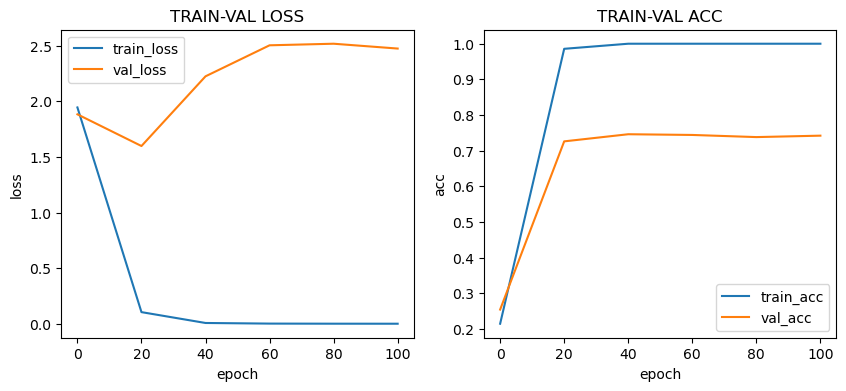

In [17]:
visualize_results(results=results)

## Applying multilayer Percentron and Vanilla GNN for Facebook Page-Page dataset
* Facebook page-page dataset contains 22,470 pages (nodes)
* Page are connected when there are mutual likes
* Node features are 128-word vectors generated from user posts.
* There are 4 categories: politicians, companies, television shows and governmental organizations
* Target: classifying nodes to these 4 groups.

In [18]:
# Download Facebook page-page dataset
from torch_geometric.datasets import FacebookPagePage

dataset = FacebookPagePage(root='.')
data = dataset[0]

Processing...
Done!


In [19]:
# create train, validation and test masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

## using MLP model

In [20]:
# create an mlp instance
model = mlp(
    dim_in=dataset.num_features,
    dim_h=16,
    dim_out=dataset.num_classes
)
model

mlp(
  (mlpBlock): Sequential(
    (0): Linear(in_features=128, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [21]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=5e-4)

In [22]:
results = train(
    model=model,
    data=data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=101,
    print_results=True
)

  0%|          | 0/101 [00:00<?, ?it/s]

    0 | 1.386 | 0.273 | 1.394 | 0.269
   20 | 0.657 | 0.743 | 0.668 | 0.740
   40 | 0.571 | 0.771 | 0.616 | 0.743
   60 | 0.543 | 0.782 | 0.601 | 0.754
   80 | 0.527 | 0.788 | 0.598 | 0.758
  100 | 0.514 | 0.794 | 0.600 | 0.759


In [23]:
test_acc = test(
    model=model,
    data=data
)

print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 75.0(%)


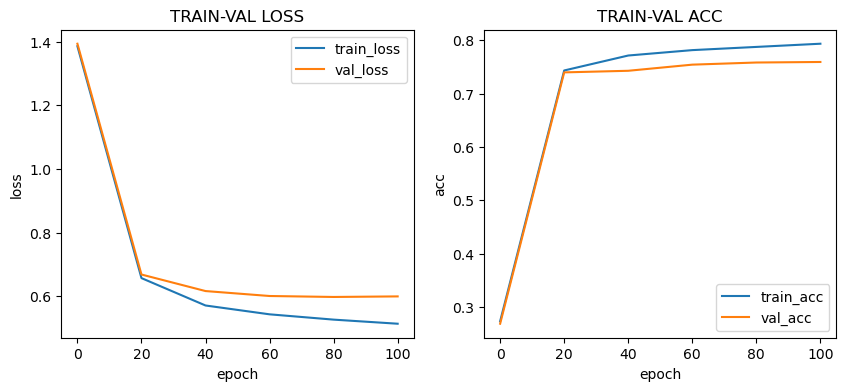

In [24]:
visualize_results(results=results)

## using Vanilla GNN model

In [25]:
# create a vanilla graph instance
model = VanillaGNN(
    dim_in=dataset.num_features,
    dim_h=16,
    dim_out=dataset.num_classes
)
model

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)

In [26]:
# create adjacency matrix (A tilde)
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [27]:
# setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=5e-4)

In [28]:
results = train(
    model=model,
    data=data,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=101,
    adjacency=adjacency,
    print_results=True
)

  0%|          | 0/101 [00:00<?, ?it/s]

    0 | 52.299 | 0.200 | 50.297 | 0.217
   20 | 2.645 | 0.798 | 2.012 | 0.804
   40 | 2.847 | 0.816 | 1.972 | 0.817
   60 | 1.219 | 0.836 | 0.881 | 0.831
   80 | 0.766 | 0.852 | 0.625 | 0.848
  100 | 0.595 | 0.857 | 0.551 | 0.855


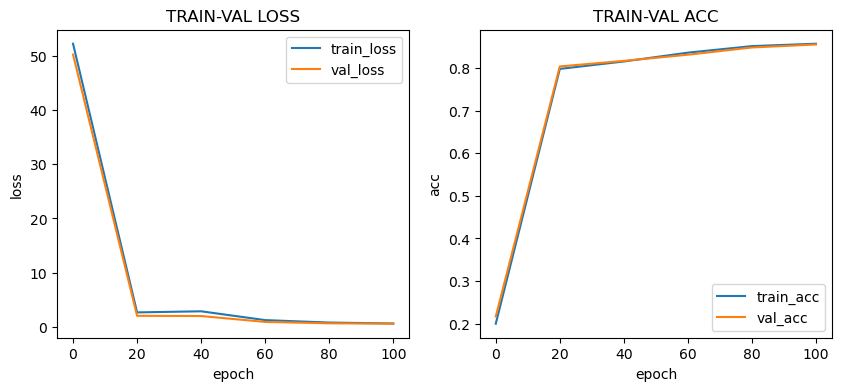

In [29]:
visualize_results(results=results)

In [30]:
test_acc = test(
    model=model,
    data=data,
    adjacency=adjacency
)

print(f"Test accuracy: {test_acc*100:.1f}(%)")

Test accuracy: 84.6(%)
